# Transformers & Large Language Model (LLM) Fundamentals

**A Step-by-Step Journey from Raw Text to AI-Generated Content**

This notebook introduces Transformers and LLMs to beginners, walking through the complete pipeline from raw text data to AI-generated content. We'll use a small real-world dataset and build understanding progressively.

## Learning Objectives

By the end of this notebook, you will understand:
- How text is converted into numbers (tokenization)
- How words become vectors (embeddings)
- How Transformers process text (forward pass)
- How models generate new text (inference)
- Practical applications of LLMs

Let's begin!


In [ ]:
# Install required libraries (run this cell first if needed)
# Uncomment the line below if you need to install packages
# !pip install transformers torch datasets numpy pandas matplotlib seaborn scikit-learn sentence-transformers


In [ ]:
# Import all necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    AutoModel,
    pipeline,
    GPT2Tokenizer,
    GPT2LMHeadModel
)
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


---

## Section 1: Small Real NLP Dataset

**What is an NLP dataset?** 

An NLP (Natural Language Processing) dataset is a collection of text data that we use to train or test language models. Real-world datasets can contain news articles, reviews, conversations, or any text that represents human language.

**Why do we need datasets?**

- Models learn patterns from data
- We need examples to understand how models work
- Real data helps us see practical applications

Let's load a small, real-world text dataset to work with throughout this notebook.


In [ ]:
# Load a small subset of AG News dataset (news headlines)
# This is a real-world dataset containing news article headlines
print("Loading dataset...")
dataset = load_dataset("ag_news", split="train[:20]")  # Get first 20 samples

# Extract just the text (headlines)
text_samples = [item['text'] for item in dataset]

# Display the raw text samples
print(f"\nLoaded {len(text_samples)} text samples\n")
print("=" * 80)
print("RAW TEXT SAMPLES FROM DATASET:")
print("=" * 80)

# Create a DataFrame for better visualization
df_samples = pd.DataFrame({
    'Sample #': range(1, len(text_samples) + 1),
    'Text': text_samples
})

# Display first 10 samples
print("\nFirst 10 samples:")
print(df_samples.head(10).to_string(index=False))

# Show some statistics
print(f"\n{'='*80}")
print(f"Dataset Statistics:")
print(f"  Total samples: {len(text_samples)}")
print(f"  Average text length: {np.mean([len(text) for text in text_samples]):.1f} characters")
print(f"  Shortest text: {min([len(text) for text in text_samples])} characters")
print(f"  Longest text: {max([len(text) for text in text_samples])} characters")
print(f"{'='*80}")


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


Loaded 20 text samples

RAW TEXT SAMPLES FROM DATASET:

First 10 samples:
 Sample #                                                                                                                                                                                                                                                                                                                                                                                                                           Text
        1                                                                                                                                                                                                                                                                               Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
        2                                                                  

**What did we just do, and why does it matter?**

We loaded a real-world NLP dataset containing news headlines. This gives us actual text data to work with, not made-up examples. Throughout this notebook, we'll use this same dataset to see how Transformers process real human language.

**Key takeaway:** NLP models work with real text data. Understanding the raw input helps us understand what happens at each step of processing.


---

## Section 2: Raw Text → Tokenization

**Why do we need tokenization?**

Computers don't understand words - they understand numbers. Tokenization is the process of breaking text into smaller pieces (called **tokens**) and converting them into numbers that the model can process.

**What are tokens?**

Tokens are the basic units of text that a model understands. They can be:
- Whole words: "hello" → one token
- Parts of words: "unhappiness" → ["un", "happiness"] → two tokens
- Characters: In some cases, individual characters

Let's see how our dataset text gets converted into tokens!


In [ ]:
# Load the GPT-2 tokenizer
# This tokenizer knows how to break text into tokens that GPT-2 understands
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Let's tokenize the first few samples from our dataset
print("=" * 80)
print("TOKENIZATION DEMONSTRATION")
print("=" * 80)

# Take first 3 samples for detailed inspection
for i, text in enumerate(text_samples[:3], 1):
    print(f"\n{'─'*80}")
    print(f"Sample {i}:")
    print(f"Original text: {text[:100]}...")  # Show first 100 chars
    
    # Tokenize the text
    # This converts text into token IDs (numbers)
    tokens = tokenizer.encode(text, return_tensors="pt")  # return_tensors="pt" gives PyTorch tensors
    token_ids = tokens[0].tolist()  # Convert to list for easier viewing
    
    # Also get the token strings (what the tokens actually are)
    token_strings = tokenizer.convert_ids_to_tokens(token_ids)
    
    print(f"\nNumber of tokens: {len(token_ids)}")
    print(f"\nFirst 20 token IDs: {token_ids[:20]}")
    print(f"\nFirst 20 token strings: {token_strings[:20]}")
    
    # Create a comparison table
    comparison_df = pd.DataFrame({
        'Position': range(1, min(21, len(token_ids) + 1)),
        'Token String': token_strings[:20],
        'Token ID': token_ids[:20]
    })
    print(f"\nToken String → Token ID mapping (first 20 tokens):")
    print(comparison_df.to_string(index=False))


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

TOKENIZATION DEMONSTRATION

────────────────────────────────────────────────────────────────────────────────
Sample 1:
Original text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...

Number of tokens: 37

First 20 token IDs: [22401, 520, 13, 15682, 30358, 5157, 20008, 262, 2619, 357, 12637, 8, 8428, 532, 10073, 12, 7255, 364, 11, 5007]

First 20 token strings: ['Wall', 'ĠSt', '.', 'ĠBears', 'ĠClaw', 'ĠBack', 'ĠInto', 'Ġthe', 'ĠBlack', 'Ġ(', 'Reuters', ')', 'ĠReuters', 'Ġ-', 'ĠShort', '-', 'sell', 'ers', ',', 'ĠWall']

Token String → Token ID mapping (first 20 tokens):
 Position Token String  Token ID
        1         Wall     22401
        2          ĠSt       520
        3            .        13
        4       ĠBears     15682
        5        ĠClaw     30358
        6        ĠBack      5157
        7        ĠInto     20008
        8         Ġthe       262
        9       ĠBlack      2619
       10           Ġ(       357
      

In [ ]:
# Visualize tokenization for one complete sentence
sample_text = text_samples[0]
print(f"\n{'='*80}")
print(f"COMPLETE TOKENIZATION BREAKDOWN")
print(f"{'='*80}")
print(f"\nOriginal text:\n{sample_text}\n")

# Get tokens
tokens = tokenizer.tokenize(sample_text)  # Get token strings
token_ids = tokenizer.encode(sample_text)  # Get token IDs

# Create a detailed table
token_table = pd.DataFrame({
    'Token': tokens,
    'Token ID': token_ids,
    'Decoded Back': [tokenizer.decode([tid]) for tid in token_ids]
})

print("Full tokenization table:")
print(token_table.to_string(index=False))

print(f"\n{'─'*80}")
print(f"Summary:")
print(f"  Original text length: {len(sample_text)} characters")
print(f"  Number of tokens: {len(tokens)}")
print(f"  Average characters per token: {len(sample_text) / len(tokens):.2f}")
print(f"{'─'*80}")



COMPLETE TOKENIZATION BREAKDOWN

Original text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Full tokenization table:
     Token  Token ID Decoded Back
      Wall     22401         Wall
       ĠSt       520           St
         .        13            .
    ĠBears     15682        Bears
     ĠClaw     30358         Claw
     ĠBack      5157         Back
     ĠInto     20008         Into
      Ġthe       262          the
    ĠBlack      2619        Black
        Ġ(       357            (
   Reuters     12637      Reuters
         )         8            )
  ĠReuters      8428      Reuters
        Ġ-       532            -
    ĠShort     10073        Short
         -        12            -
      sell      7255         sell
       ers       364          ers
         ,        11            ,
     ĠWall      5007         Wall
   ĠStreet      3530       Street
        's       338           '

**What did we just do, and why does it matter?**

We converted raw text into **tokens** (numbers). This is the first step in any NLP pipeline. Notice how:
- One word can become multiple tokens (subword tokenization)
- Each token has a unique ID number
- The tokenizer can convert back: IDs → text

**Key takeaway:** Tokenization bridges human language (text) and machine language (numbers). Without this step, models couldn't process text at all!


---

## Section 3: Tokenization Variants

**What is subword tokenization?**

Instead of treating each word as one token, modern tokenizers break words into smaller pieces. This helps handle:
- **Out-of-Vocabulary (OOV) words**: Words the model has never seen
- **Large vocabularies**: Instead of storing every possible word, we store word parts
- **Efficiency**: Fewer unique tokens needed

**Common tokenization strategies:**
- **BPE (Byte Pair Encoding)**: Used by GPT models
- **WordPiece**: Used by BERT models
- **SentencePiece**: Used by some multilingual models

Let's compare how different sentences get tokenized!


In [ ]:
# Compare tokenization across multiple sentences
print("=" * 80)
print("TOKENIZATION VARIATION ACROSS SENTENCES")
print("=" * 80)

# Select 5 different samples
comparison_samples = text_samples[:5]

# Store results for comparison
tokenization_results = []

for i, text in enumerate(comparison_samples, 1):
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text)
    
    tokenization_results.append({
        'Sample #': i,
        'Text Length (chars)': len(text),
        'Number of Tokens': len(tokens),
        'Tokens per Character': len(tokens) / len(text),
        'First 10 Tokens': ' '.join(tokens[:10])
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(tokenization_results)
print("\nTokenization comparison:")
print(comparison_df.to_string(index=False))


TOKENIZATION VARIATION ACROSS SENTENCES

Tokenization comparison:
 Sample #  Text Length (chars)  Number of Tokens  Tokens per Character                                             First 10 Tokens
        1                  144                37              0.256944          Wall ĠSt . ĠBears ĠClaw ĠBack ĠInto Ġthe ĠBlack Ġ(
        2                  266                55              0.206767 Car ly le ĠLooks ĠTow ard ĠCommercial ĠAerospace Ġ( Reuters
        3                  232                51              0.219828     Oil Ġand ĠEconomy ĠCloud ĠSt ocks ' ĠOutlook Ġ( Reuters
        4                  256                49              0.191406 Iraq ĠHal ts ĠOil ĠEx ports Ġfrom ĠMain ĠSouthern ĠPipeline
        5                  234                49              0.209402         Oil Ġprices Ġsoar Ġto Ġall - time Ġrecord , Ġposing


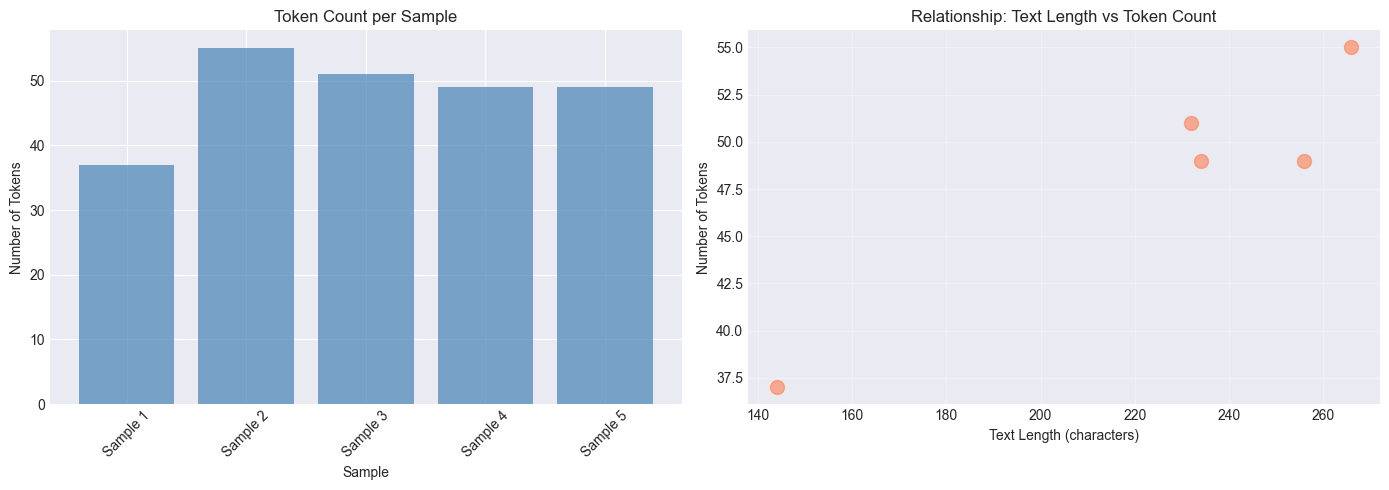


Average tokens per character: 0.217
Token count range: 37 - 55 tokens


In [ ]:
# Visualize token length differences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Number of tokens per sample
sample_nums = [f"Sample {i+1}" for i in range(len(comparison_samples))]
token_counts = [len(tokenizer.tokenize(text)) for text in comparison_samples]
char_counts = [len(text) for text in comparison_samples]

axes[0].bar(sample_nums, token_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Number of Tokens')
axes[0].set_title('Token Count per Sample')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Tokens vs Characters
axes[1].scatter(char_counts, token_counts, s=100, alpha=0.6, color='coral')
axes[1].set_xlabel('Text Length (characters)')
axes[1].set_ylabel('Number of Tokens')
axes[1].set_title('Relationship: Text Length vs Token Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage tokens per character: {np.mean([t/c for t, c in zip(token_counts, char_counts)]):.3f}")
print(f"Token count range: {min(token_counts)} - {max(token_counts)} tokens")


In [ ]:
# Demonstrate OOV (Out-of-Vocabulary) handling
print("=" * 80)
print("OUT-OF-VOCABULARY (OOV) WORD HANDLING")
print("=" * 80)

# Test with a made-up word and a real word
test_words = ["hello", "supercalifragilisticexpialidocious", "GPT-3", "COVID-19"]

print("\nHow the tokenizer handles different words:\n")
for word in test_words:
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.encode(word)
    
    print(f"Word: '{word}'")
    print(f"  → Tokens: {tokens}")
    print(f"  → Token IDs: {token_ids}")
    print(f"  → Number of tokens: {len(tokens)}")
    print()

# Show vocabulary size
vocab_size = tokenizer.vocab_size
print(f"{'─'*80}")
print(f"Vocabulary size: {vocab_size:,} unique tokens")
print(f"This means the tokenizer knows {vocab_size:,} different token pieces")
print(f"{'─'*80}")


OUT-OF-VOCABULARY (OOV) WORD HANDLING

How the tokenizer handles different words:

Word: 'hello'
  → Tokens: ['hello']
  → Token IDs: [31373]
  → Number of tokens: 1

Word: 'supercalifragilisticexpialidocious'
  → Tokens: ['super', 'cal', 'if', 'rag', 'il', 'ist', 'ice', 'xp', 'ial', 'id', 'ocious']
  → Token IDs: [16668, 9948, 361, 22562, 346, 396, 501, 42372, 498, 312, 32346]
  → Number of tokens: 11

Word: 'GPT-3'
  → Tokens: ['G', 'PT', '-', '3']
  → Token IDs: [38, 11571, 12, 18]
  → Number of tokens: 4

Word: 'COVID-19'
  → Tokens: ['CO', 'VID', '-', '19']
  → Token IDs: [8220, 11008, 12, 1129]
  → Number of tokens: 4

────────────────────────────────────────────────────────────────────────────────
Vocabulary size: 50,257 unique tokens
This means the tokenizer knows 50,257 different token pieces
────────────────────────────────────────────────────────────────────────────────


**What did we just do, and why does it matter?**

We saw how tokenization varies across different texts and how subword tokenization handles unknown words. Key insights:
- Different sentences produce different numbers of tokens
- Long words get broken into multiple tokens
- The tokenizer has a fixed vocabulary size (50,257 tokens for GPT-2)
- OOV words are handled by breaking them into known subword pieces

**Key takeaway:** Subword tokenization is powerful because it can handle any text, even with words the model has never seen, by breaking them into known pieces.


---

## Section 4: Tokens → Vectorization → Embeddings

**What are embeddings?**

**Embeddings** are numerical representations of tokens in a high-dimensional space. Think of them as coordinates that capture the meaning of words. Words with similar meanings have similar embeddings (they're close together in this space).

**Why embeddings matter:**
- They convert discrete token IDs into continuous vectors
- They capture semantic relationships (similar words = similar vectors)
- They're what the model actually processes

Let's convert our tokens into embeddings and visualize them!


In [ ]:
# Load a model to get embeddings
# We'll use DistilBERT for embeddings (it's smaller and faster)
print("Loading model for embeddings...")
embedding_model = AutoModel.from_pretrained("distilbert-base-uncased")
embedding_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Set model to evaluation mode (no training)
embedding_model.eval()

print("Model loaded successfully!")
print(f"Model has {sum(p.numel() for p in embedding_model.parameters()):,} parameters")


Loading model for embeddings...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model loaded successfully!
Model has 66,362,880 parameters


In [ ]:
# Convert tokens to embeddings for one sample
sample_text = text_samples[0]
print("=" * 80)
print("TOKEN → EMBEDDING CONVERSION")
print("=" * 80)
print(f"\nSample text: {sample_text}\n")

# Step 1: Tokenize
tokens = embedding_tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True)
print("Step 1 - Tokenization:")
print(f"  Input tokens shape: {tokens['input_ids'].shape}")
print(f"  Token IDs: {tokens['input_ids'][0][:10].tolist()}... (showing first 10)")

# Step 2: Get embeddings
# The model's embedding layer converts token IDs to embedding vectors
with torch.no_grad():  # Don't compute gradients (we're just doing inference)
    outputs = embedding_model(**tokens)
    embeddings = outputs.last_hidden_state  # This contains the embeddings

print(f"\nStep 2 - Embeddings:")
print(f"  Embedding tensor shape: {embeddings.shape}")
print(f"  This means: [batch_size={embeddings.shape[0]}, sequence_length={embeddings.shape[1]}, hidden_size={embeddings.shape[2]}]")
print(f"  Each token is now represented by a {embeddings.shape[2]}-dimensional vector!")

# Show a slice of embedding values
print(f"\nStep 3 - Embedding values (first token, first 10 dimensions):")
print(f"  {embeddings[0][0][:10].tolist()}")
print(f"  (These are just numbers - coordinates in a {embeddings.shape[2]}-dimensional space)")


TOKEN → EMBEDDING CONVERSION

Sample text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Step 1 - Tokenization:
  Input tokens shape: torch.Size([1, 41])
  Token IDs: [101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304]... (showing first 10)

Step 2 - Embeddings:
  Embedding tensor shape: torch.Size([1, 41, 768])
  This means: [batch_size=1, sequence_length=41, hidden_size=768]
  Each token is now represented by a 768-dimensional vector!

Step 3 - Embedding values (first token, first 10 dimensions):
  [-0.15147730708122253, 0.01465865783393383, 0.12211678922176361, -0.20313900709152222, -0.2553192377090454, -0.20558862388134003, 0.21467319130897522, 0.541618287563324, -0.26740971207618713, -0.4011862576007843]
  (These are just numbers - coordinates in a 768-dimensional space)


In [ ]:
# Get sentence-level embeddings (average of token embeddings)
# This gives us one vector per sentence
print("=" * 80)
print("SENTENCE-LEVEL EMBEDDINGS")
print("=" * 80)

sentence_embeddings = []

for i, text in enumerate(text_samples[:5], 1):
    tokens = embedding_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    with torch.no_grad():
        outputs = embedding_model(**tokens)
        # Get the [CLS] token embedding (special token that represents the whole sentence)
        # Or average all token embeddings
        token_embeddings = outputs.last_hidden_state[0]  # Remove batch dimension
        sentence_embedding = token_embeddings.mean(dim=0)  # Average across tokens
        sentence_embeddings.append(sentence_embedding.numpy())
    
    print(f"Sample {i}: {len(text)} chars → {sentence_embedding.shape[0]}-dim embedding vector")

sentence_embeddings = np.array(sentence_embeddings)
print(f"\nAll sentence embeddings shape: {sentence_embeddings.shape}")
print(f"This means we have {sentence_embeddings.shape[0]} sentences, each represented by a {sentence_embeddings.shape[1]}-dimensional vector")


SENTENCE-LEVEL EMBEDDINGS
Sample 1: 144 chars → 768-dim embedding vector
Sample 2: 266 chars → 768-dim embedding vector
Sample 3: 232 chars → 768-dim embedding vector
Sample 4: 256 chars → 768-dim embedding vector
Sample 5: 234 chars → 768-dim embedding vector

All sentence embeddings shape: (5, 768)
This means we have 5 sentences, each represented by a 768-dimensional vector


VISUALIZING EMBEDDINGS IN 2D


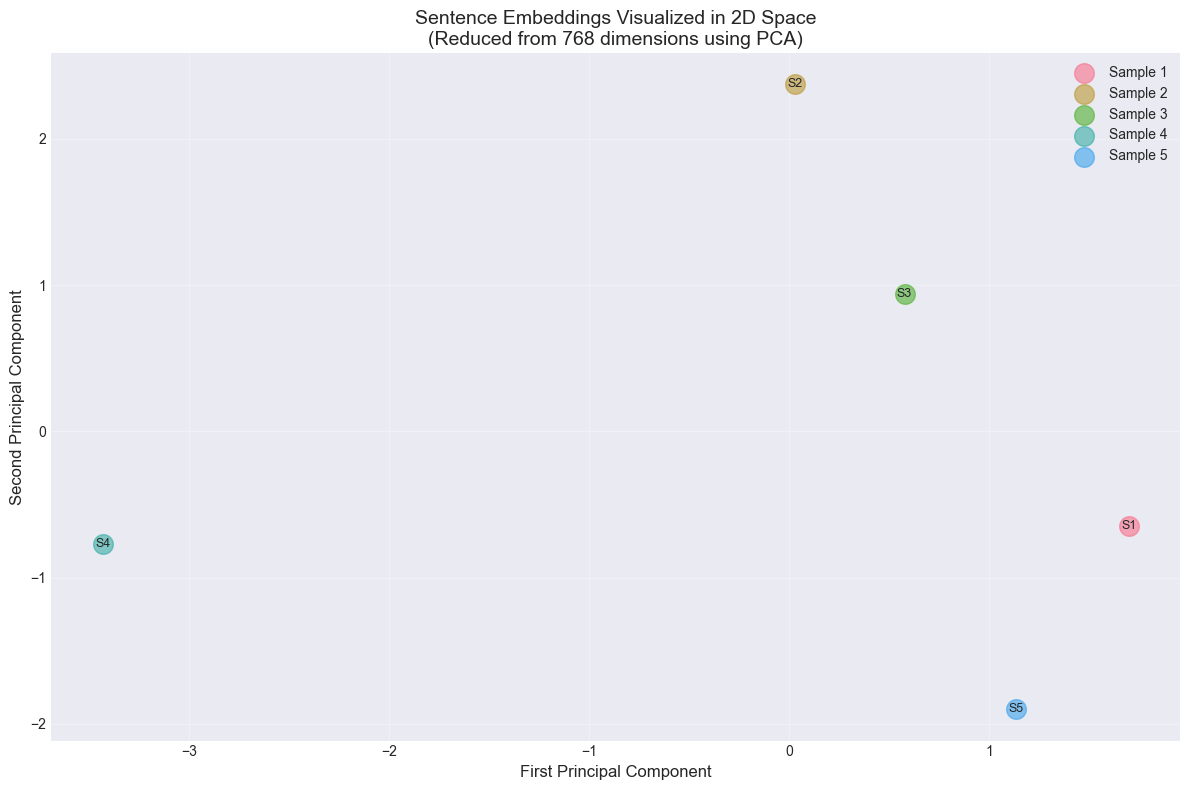


Explained variance by 2D projection: 63.31%
This means we're showing 63.3% of the original information in 2D

Note: Points closer together in this space have more similar meanings!


In [ ]:
# Visualize embeddings in 2D using PCA (Principal Component Analysis)
# We'll reduce the high-dimensional embeddings to 2D so we can plot them
print("=" * 80)
print("VISUALIZING EMBEDDINGS IN 2D")
print("=" * 80)

# Reduce dimensions from 768 to 2 using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sentence_embeddings)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each sentence as a point
for i, (x, y) in enumerate(embeddings_2d):
    ax.scatter(x, y, s=200, alpha=0.6, label=f'Sample {i+1}')
    # Add text label
    ax.annotate(f'S{i+1}', (x, y), fontsize=9, ha='center', va='center')

ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title('Sentence Embeddings Visualized in 2D Space\n(Reduced from 768 dimensions using PCA)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.show()

print(f"\nExplained variance by 2D projection: {pca.explained_variance_ratio_.sum():.2%}")
print("This means we're showing {:.1f}% of the original information in 2D".format(pca.explained_variance_ratio_.sum() * 100))
print("\nNote: Points closer together in this space have more similar meanings!")


**What did we just do, and why does it matter?**

We converted token IDs into **embeddings** - high-dimensional vectors that capture semantic meaning. Key insights:
- Each token becomes a 768-dimensional vector (for DistilBERT)
- Sentences can be represented as single embedding vectors
- Similar sentences have similar embeddings (close in vector space)
- We can visualize embeddings in 2D, though we lose some information

**Key takeaway:** Embeddings are the "language" that Transformers understand. They convert discrete tokens into continuous mathematical representations that capture meaning.


---

## Section 5: Semantic Similarity on Real Text

**What is semantic similarity?**

**Semantic similarity** measures how similar two pieces of text are in meaning, not just in words. For example:
- "I love dogs" and "I adore canines" are semantically similar (different words, same meaning)
- "I love dogs" and "I hate cats" are less similar (different meanings)

**How do we measure it?**

We use **cosine similarity** between embedding vectors. If two embeddings point in similar directions (high cosine similarity), the texts have similar meanings.

Let's compute similarities between our dataset sentences!


In [ ]:
# Compute cosine similarity between all sentence pairs
print("=" * 80)
print("SEMANTIC SIMILARITY COMPUTATION")
print("=" * 80)

# Get embeddings for more samples (let's use 8 samples)
num_samples = 8
sample_texts = text_samples[:num_samples]
sample_embeddings_list = []

for text in sample_texts:
    tokens = embedding_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = embedding_model(**tokens)
        token_embeddings = outputs.last_hidden_state[0]
        sentence_embedding = token_embeddings.mean(dim=0).numpy()
        sample_embeddings_list.append(sentence_embedding)

sample_embeddings = np.array(sample_embeddings_list)

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(sample_embeddings)

print(f"\nComputed similarity matrix shape: {similarity_matrix.shape}")
print(f"This shows similarity between all {num_samples} sentence pairs\n")


SEMANTIC SIMILARITY COMPUTATION

Computed similarity matrix shape: (8, 8)
This shows similarity between all 8 sentence pairs



In [ ]:
# Display similarity matrix as a table
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=[f"Sample {i+1}" for i in range(num_samples)],
    columns=[f"Sample {i+1}" for i in range(num_samples)]
)

print("Cosine Similarity Matrix:")
print("(Values range from -1 to 1, where 1 = identical meaning, 0 = unrelated, -1 = opposite)")
print("\n" + similarity_df.to_string())
print(f"\nNote: Diagonal values are 1.0 (each sentence is identical to itself)")


Cosine Similarity Matrix:
(Values range from -1 to 1, where 1 = identical meaning, 0 = unrelated, -1 = opposite)

          Sample 1  Sample 2  Sample 3  Sample 4  Sample 5  Sample 6  Sample 7  Sample 8
Sample 1  1.000000  0.826052  0.832797  0.743050  0.850915  0.855583  0.805194  0.811077
Sample 2  0.826052  1.000000  0.860514  0.785954  0.807056  0.856525  0.837742  0.800525
Sample 3  0.832797  0.860514  1.000000  0.781289  0.853291  0.935398  0.879722  0.870633
Sample 4  0.743050  0.785954  0.781289  1.000000  0.770926  0.787700  0.753827  0.791589
Sample 5  0.850915  0.807056  0.853291  0.770926  1.000000  0.841422  0.821733  0.858285
Sample 6  0.855583  0.856525  0.935398  0.787700  0.841422  1.000000  0.892861  0.899895
Sample 7  0.805194  0.837742  0.879722  0.753827  0.821733  0.892861  1.000000  0.892380
Sample 8  0.811077  0.800525  0.870633  0.791589  0.858285  0.899895  0.892380  1.000000

Note: Diagonal values are 1.0 (each sentence is identical to itself)


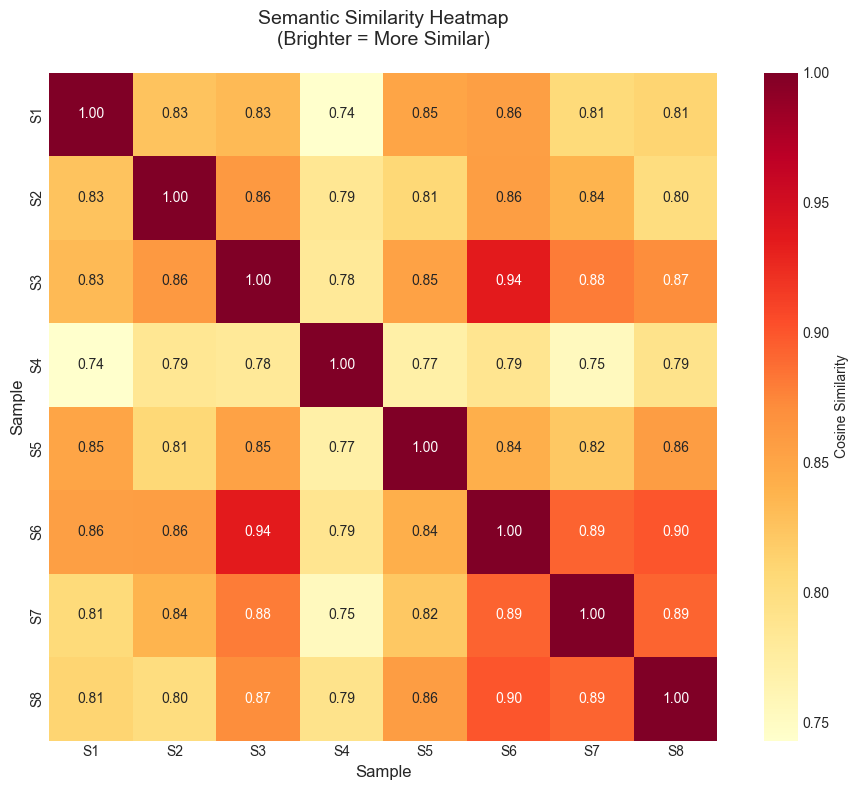

Interpretation:
- Bright yellow/red cells = high similarity (similar meanings)
- Dark cells = low similarity (different meanings)
- Diagonal is always bright (each sentence is identical to itself)


In [ ]:
# Visualize similarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    square=True,
    xticklabels=[f"S{i+1}" for i in range(num_samples)],
    yticklabels=[f"S{i+1}" for i in range(num_samples)],
    cbar_kws={'label': 'Cosine Similarity'},
    ax=ax
)

ax.set_title('Semantic Similarity Heatmap\n(Brighter = More Similar)', fontsize=14, pad=20)
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('Sample', fontsize=12)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Bright yellow/red cells = high similarity (similar meanings)")
print("- Dark cells = low similarity (different meanings)")
print("- Diagonal is always bright (each sentence is identical to itself)")


In [ ]:
# Find most similar and least similar pairs
print("=" * 80)
print("MOST SIMILAR AND LEAST SIMILAR PAIRS")
print("=" * 80)

# Get upper triangle (avoid diagonal and duplicates)
upper_triangle = np.triu(similarity_matrix, k=1)
max_sim_idx = np.unravel_index(np.argmax(upper_triangle), similarity_matrix.shape)
min_sim_idx = np.unravel_index(np.argmin(upper_triangle[upper_triangle > 0]), similarity_matrix.shape)

print(f"\nMost Similar Pair (similarity = {similarity_matrix[max_sim_idx]:.3f}):")
print(f"  Sample {max_sim_idx[0]+1}: {sample_texts[max_sim_idx[0]][:80]}...")
print(f"  Sample {max_sim_idx[1]+1}: {sample_texts[max_sim_idx[1]][:80]}...")

print(f"\nLeast Similar Pair (similarity = {similarity_matrix[min_sim_idx]:.3f}):")
print(f"  Sample {min_sim_idx[0]+1}: {sample_texts[min_sim_idx[0]][:80]}...")
print(f"  Sample {min_sim_idx[1]+1}: {sample_texts[min_sim_idx[1]][:80]}...")

print(f"\n{'─'*80}")
print("Key Insight: Even though these are all news headlines, some are more")
print("semantically similar than others based on their topics and wording!")
print(f"{'─'*80}")


MOST SIMILAR AND LEAST SIMILAR PAIRS

Most Similar Pair (similarity = 0.935):
  Sample 3: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices p...
  Sample 6: Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly high...

Least Similar Pair (similarity = 0.833):
  Sample 1: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall ...
  Sample 3: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices p...

────────────────────────────────────────────────────────────────────────────────
Key Insight: Even though these are all news headlines, some are more
semantically similar than others based on their topics and wording!
────────────────────────────────────────────────────────────────────────────────


**What did we just do, and why does it matter?**

We computed **semantic similarity** between sentences using their embeddings. This demonstrates:
- How embeddings capture meaning (not just words)
- How we can measure similarity mathematically (cosine similarity)
- That similar meanings result in similar vectors (geometric interpretation)

**Key takeaway:** Embeddings enable semantic understanding. By comparing vectors, we can find texts with similar meanings, which powers search engines, recommendation systems, and chatbots!


---

## Section 6: Transformer Model Forward Pass

**What is a forward pass?**

A **forward pass** is when we feed input tokens through the Transformer model and get output representations. The model processes tokens through multiple layers, applying **attention** mechanisms to understand relationships between words.

**What happens during a forward pass?**

1. Tokens → Embeddings (we saw this!)
2. Embeddings → Contextual representations (this is new!)
3. Each layer refines the understanding
4. Final output: rich representations that understand context

Let's load a Transformer model and see what happens during a forward pass!


In [ ]:
# Load GPT-2 model for text generation
# GPT-2 is a Transformer model that can generate text
print("Loading GPT-2 model...")
print("(This may take a minute on first run - the model is ~500MB)")

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")

# Set padding token (GPT-2 doesn't have one by default)
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

model.eval()  # Set to evaluation mode
print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: ~{sum(p.numel() * 4 for p in model.parameters()) / 1e9:.1f} GB (in float32)")


Loading GPT-2 model...
(This may take a minute on first run - the model is ~500MB)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully!
Model parameters: 124,439,808
Model size: ~0.5 GB (in float32)


In [ ]:
# Perform a forward pass on our dataset text
print("=" * 80)
print("TRANSFORMER FORWARD PASS")
print("=" * 80)

sample_text = text_samples[0]
print(f"\nInput text: {sample_text}\n")

# Step 1: Tokenize
input_ids = tokenizer_gpt2.encode(sample_text, return_tensors="pt")
print(f"Step 1 - Tokenization:")
print(f"  Input token IDs shape: {input_ids.shape}")
print(f"  Number of tokens: {input_ids.shape[1]}")

# Step 2: Forward pass through the model
# This is where the magic happens - the model processes the tokens
print(f"\nStep 2 - Forward Pass:")
print("  Processing tokens through Transformer layers...")

with torch.no_grad():
    outputs = model(input_ids)
    
    # The model returns:
    # - logits: predictions for next token (vocabulary_size)
    # - hidden_states: representations at each layer (if requested)
    
    logits = outputs.logits
    print(f"  Output logits shape: {logits.shape}")
    print(f"  This means: [batch_size={logits.shape[0]}, sequence_length={logits.shape[1]}, vocab_size={logits.shape[2]}]")
    print(f"  For each token position, the model predicts probabilities over {logits.shape[2]:,} possible next tokens!")

print(f"\n{'─'*80}")
print("What just happened?")
print("The model processed each token through multiple Transformer layers,")
print("applying attention to understand context, and produced predictions")
print("for what token should come next at each position.")
print(f"{'─'*80}")


TRANSFORMER FORWARD PASS

Input text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Step 1 - Tokenization:
  Input token IDs shape: torch.Size([1, 37])
  Number of tokens: 37

Step 2 - Forward Pass:
  Processing tokens through Transformer layers...
  Output logits shape: torch.Size([1, 37, 50257])
  This means: [batch_size=1, sequence_length=37, vocab_size=50257]
  For each token position, the model predicts probabilities over 50,257 possible next tokens!

────────────────────────────────────────────────────────────────────────────────
What just happened?
The model processed each token through multiple Transformer layers,
applying attention to understand context, and produced predictions
for what token should come next at each position.
────────────────────────────────────────────────────────────────────────────────


In [ ]:
# Show intermediate representations (if available)
# Let's also see what the model's hidden states look like
print("=" * 80)
print("MODEL ARCHITECTURE INSIGHTS")
print("=" * 80)

# Get model configuration
config = model.config
print(f"\nModel Configuration:")
print(f"  Number of layers: {config.n_layer}")
print(f"  Hidden size: {config.n_embd}")
print(f"  Number of attention heads: {config.n_head}")
print(f"  Vocabulary size: {config.vocab_size}")
print(f"  Maximum context length: {config.n_positions} tokens")

print(f"\n{'─'*80}")
print("Key Terminology:")
print("  • Layers: Each layer refines the understanding (GPT-2 has 12 layers)")
print("  • Hidden size: Dimension of internal representations (768 for GPT-2)")
print("  • Attention heads: Different ways to look at relationships (12 heads)")
print("  • Context length: Maximum tokens the model can process at once")
print(f"{'─'*80}")


MODEL ARCHITECTURE INSIGHTS

Model Configuration:
  Number of layers: 12
  Hidden size: 768
  Number of attention heads: 12
  Vocabulary size: 50257
  Maximum context length: 1024 tokens

────────────────────────────────────────────────────────────────────────────────
Key Terminology:
  • Layers: Each layer refines the understanding (GPT-2 has 12 layers)
  • Hidden size: Dimension of internal representations (768 for GPT-2)
  • Attention heads: Different ways to look at relationships (12 heads)
  • Context length: Maximum tokens the model can process at once
────────────────────────────────────────────────────────────────────────────────


**What did we just do, and why does it matter?**

We performed a **forward pass** through a Transformer model. This showed:
- How tokens flow through the model
- What the model outputs (logits - predictions for next tokens)
- The model's architecture (layers, hidden size, attention heads)
- That the model understands context (not just individual words)

**Key takeaway:** The forward pass is where Transformers work their magic. They process tokens through multiple layers with attention, building rich contextual understanding that enables text generation and understanding.


---

## Section 7: Token-Level Outputs & Logits

**What are logits?**

**Logits** are the raw, unnormalized predictions that the model outputs. For each position, the model produces a logit score for every possible token in its vocabulary. Higher logits = more likely token.

**How do we use logits?**

1. Convert logits to probabilities (using softmax)
2. Select the next token (argmax = most likely, or sampling for variety)
3. Use this to generate text one token at a time

Let's inspect the logits from our forward pass!


In [ ]:
# Inspect logits from the forward pass
print("=" * 80)
print("INSPECTING LOGITS")
print("=" * 80)

sample_text = text_samples[0]
input_ids = tokenizer_gpt2.encode(sample_text, return_tensors="pt")

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

print(f"\nInput text: {sample_text}")
print(f"\nLogits shape: {logits.shape}")
print(f"  - Batch size: {logits.shape[0]}")
print(f"  - Sequence length: {logits.shape[1]} (one prediction per token position)")
print(f"  - Vocabulary size: {logits.shape[2]} (predictions for all possible tokens)")

# Get logits for the last position (what should come after the full sentence?)
last_position_logits = logits[0, -1, :]  # Last token position, all vocabulary

print(f"\n{'─'*80}")
print(f"Logits for the LAST token position (predicting what comes next):")
print(f"  Shape: {last_position_logits.shape}")
print(f"  Min value: {last_position_logits.min():.2f}")
print(f"  Max value: {last_position_logits.max():.2f}")
print(f"  Mean value: {last_position_logits.mean():.2f}")
print(f"{'─'*80}")


INSPECTING LOGITS

Input text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Logits shape: torch.Size([1, 37, 50257])
  - Batch size: 1
  - Sequence length: 37 (one prediction per token position)
  - Vocabulary size: 50257 (predictions for all possible tokens)

────────────────────────────────────────────────────────────────────────────────
Logits for the LAST token position (predicting what comes next):
  Shape: torch.Size([50257])
  Min value: -138.36
  Max value: -94.96
  Mean value: -114.01
────────────────────────────────────────────────────────────────────────────────


In [ ]:
# Convert logits to probabilities using softmax
import torch.nn.functional as F

# Apply softmax to convert logits to probabilities
probs = F.softmax(last_position_logits, dim=-1)

print("=" * 80)
print("CONVERTING LOGITS TO PROBABILITIES")
print("=" * 80)
print(f"\nProbabilities shape: {probs.shape}")
print(f"Sum of all probabilities: {probs.sum():.4f} (should be ~1.0)")
print(f"Highest probability: {probs.max():.4f}")
print(f"Lowest probability: {probs.min():.4e}")

# Get top-k most likely tokens
top_k = 10
top_probs, top_indices = torch.topk(probs, top_k)

print(f"\n{'─'*80}")
print(f"Top {top_k} Most Likely Next Tokens:")
print(f"{'─'*80}")

top_tokens_data = []
for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    token = tokenizer_gpt2.decode([idx.item()])
    top_tokens_data.append({
        'Rank': i,
        'Token': repr(token),  # Use repr to show special characters
        'Token ID': idx.item(),
        'Probability': f"{prob.item():.4f}",
        'Percentage': f"{prob.item()*100:.2f}%"
    })

top_tokens_df = pd.DataFrame(top_tokens_data)
print(top_tokens_df.to_string(index=False))


CONVERTING LOGITS TO PROBABILITIES

Probabilities shape: torch.Size([50257])
Sum of all probabilities: 1.0000 (should be ~1.0)
Highest probability: 0.5142
Lowest probability: 7.3033e-20

────────────────────────────────────────────────────────────────────────────────
Top 10 Most Likely Next Tokens:
────────────────────────────────────────────────────────────────────────────────
 Rank   Token  Token ID Probability Percentage
    1    '\n'       198      0.5142     51.42%
    2  ' The'       383      0.0600      6.00%
    3 ' They'      1119      0.0275      2.75%
    4    ' A'       317      0.0178      1.78%
    5   ' In'       554      0.0166      1.66%
    6 ' Wall'      5007      0.0137      1.37%
    7  ' But'       887      0.0121      1.21%
    8  ' And'       843      0.0104      1.04%
    9   ' On'      1550      0.0068      0.68%
   10   ' It'       632      0.0059      0.59%


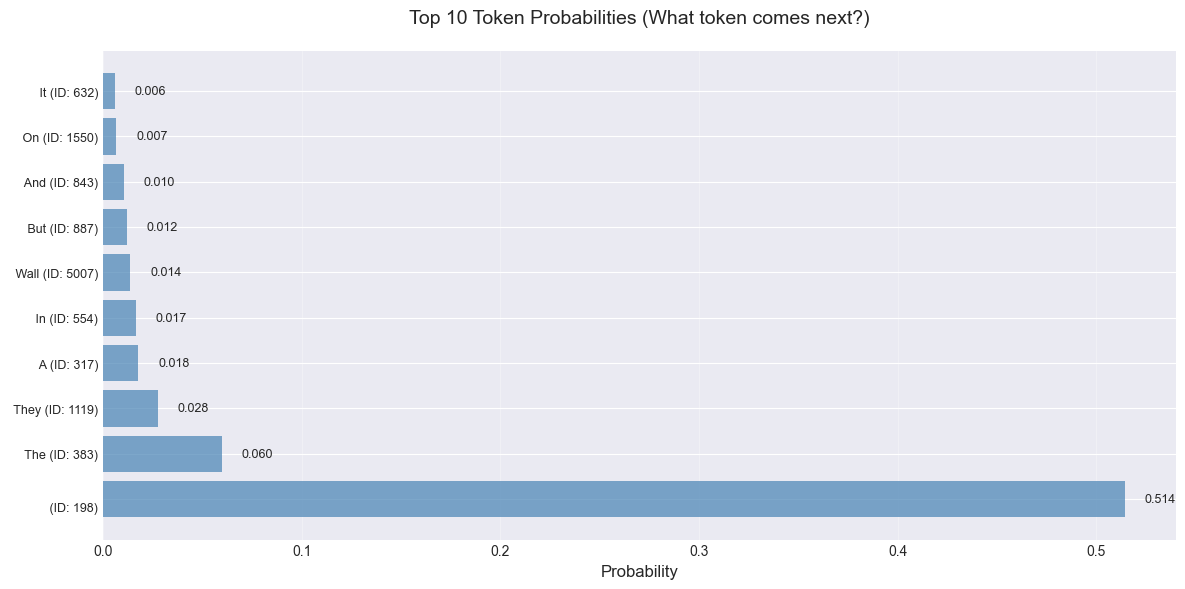


Most likely next token: '
'
  Probability: 0.5142 (51.42%)


In [ ]:
# Visualize top-k token probabilities
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for plotting
tokens_str = [tokenizer_gpt2.decode([idx.item()])[:20] for idx in top_indices]  # Truncate long tokens
probs_np = top_probs.numpy()

# Create bar plot
bars = ax.barh(range(len(tokens_str)), probs_np, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(tokens_str)))
ax.set_yticklabels([f"{t} (ID: {idx.item()})" for t, idx in zip(tokens_str, top_indices)], fontsize=9)
ax.set_xlabel('Probability', fontsize=12)
ax.set_title(f'Top {top_k} Token Probabilities (What token comes next?)', fontsize=14, pad=20)
ax.grid(True, axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, prob) in enumerate(zip(bars, probs_np)):
    ax.text(prob + 0.01, i, f'{prob:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nMost likely next token: '{tokenizer_gpt2.decode([top_indices[0].item()])}'")
print(f"  Probability: {top_probs[0].item():.4f} ({top_probs[0].item()*100:.2f}%)")


In [ ]:
# Demonstrate different token selection strategies
print("=" * 80)
print("TOKEN SELECTION STRATEGIES")
print("=" * 80)

# Strategy 1: Greedy (always pick most likely)
greedy_token_id = top_indices[0].item()
greedy_token = tokenizer_gpt2.decode([greedy_token_id])
print(f"\n1. Greedy Selection (argmax):")
print(f"   Always picks the token with highest probability")
print(f"   Selected: '{greedy_token}' (probability: {top_probs[0].item():.4f})")
print(f"   Result: Deterministic, predictable, but can be repetitive")

# Strategy 2: Top-k sampling (sample from top k tokens)
k = 5
top_k_probs = top_probs[:k]
top_k_indices = top_indices[:k]
# Normalize probabilities
top_k_probs_normalized = top_k_probs / top_k_probs.sum()
# Sample
sampled_idx = torch.multinomial(top_k_probs_normalized, 1).item()
sampled_token_id = top_k_indices[sampled_idx].item()
sampled_token = tokenizer_gpt2.decode([sampled_token_id])

print(f"\n2. Top-k Sampling (sample from top {k}):")
print(f"   Randomly picks from the {k} most likely tokens")
print(f"   Selected: '{sampled_token}' (from top {k} tokens)")
print(f"   Result: More diverse, creative, but less predictable")

print(f"\n{'─'*80}")
print("Key Insight: Different selection strategies produce different")
print("text generation styles - greedy is safe, sampling is creative!")
print(f"{'─'*80}")


TOKEN SELECTION STRATEGIES

1. Greedy Selection (argmax):
   Always picks the token with highest probability
   Selected: '
' (probability: 0.5142)
   Result: Deterministic, predictable, but can be repetitive

2. Top-k Sampling (sample from top 5):
   Randomly picks from the 5 most likely tokens
   Selected: '
' (from top 5 tokens)
   Result: More diverse, creative, but less predictable

────────────────────────────────────────────────────────────────────────────────
Key Insight: Different selection strategies produce different
text generation styles - greedy is safe, sampling is creative!
────────────────────────────────────────────────────────────────────────────────


**What did we just do, and why does it matter?**

We inspected **logits** - the model's raw predictions. Key insights:
- Logits are unnormalized scores for each possible token
- We convert them to probabilities using softmax
- We can select the next token using different strategies (greedy vs sampling)
- The model predicts probabilities over 50,257 possible tokens!

**Key takeaway:** Logits are the bridge between model understanding and text generation. By interpreting logits, we control how the model generates text - deterministically (greedy) or creatively (sampling).


---

## Section 8: End-to-End Text Generation Demo

**How does text generation work?**

Text generation is **autoregressive** - the model generates one token at a time, using previously generated tokens as context. It's like the model is "thinking out loud," building on what it has already said.

**Key parameters:**
- **Temperature**: Controls randomness (low = conservative, high = creative)
- **Max tokens**: Maximum length of generated text
- **Top-k/Top-p**: Limit sampling to most likely tokens

Let's generate text from prompts based on our dataset!


In [ ]:
# Generate text from a prompt
print("=" * 80)
print("TEXT GENERATION DEMO")
print("=" * 80)

# Use a prompt from our dataset
prompt = text_samples[0][:50]  # First 50 characters as prompt
print(f"\nPrompt: {prompt}...")
print(f"\nGenerating continuation...\n")

# Generate text
input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")

with torch.no_grad():
    # Generate with specific parameters
    generated = model.generate(
        input_ids,
        max_length=input_ids.shape[1] + 50,  # Generate 50 more tokens
        num_return_sequences=1,
        temperature=0.7,  # Moderate creativity
        do_sample=True,
        pad_token_id=tokenizer_gpt2.eos_token_id
    )

# Decode the generated text
generated_text = tokenizer_gpt2.decode(generated[0], skip_special_tokens=True)
print("Generated text:")
print(f"{generated_text}\n")
print(f"{'─'*80}")


TEXT GENERATION DEMO

Prompt: Wall St. Bears Claw Back Into the Black (Reuters) ...

Generating continuation...

Generated text:
Wall St. Bears Claw Back Into the Black (Reuters)  It's unclear if the Bears will be given a chance to make the playoffs. All of the Bears are at home in the NFC South, and the Bears have a chance to beat the Falcons in the NFC East. It's not known if the

────────────────────────────────────────────────────────────────────────────────


In [ ]:
# Show step-by-step generation process
print("=" * 80)
print("STEP-BY-STEP GENERATION PROCESS")
print("=" * 80)

prompt = "The future of artificial intelligence"
print(f"\nPrompt: '{prompt}'\n")

input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")
current_ids = input_ids.clone()

print("Generating tokens one by one...\n")
generated_tokens = []
generated_probs = []

for step in range(5):  # Generate 5 tokens
    with torch.no_grad():
        outputs = model(current_ids)
        logits = outputs.logits[0, -1, :]  # Last position
        probs = F.softmax(logits, dim=-1)
        
        # Get top token
        top_prob, top_idx = torch.topk(probs, 1)
        next_token_id = top_idx.item()
        next_token = tokenizer_gpt2.decode([next_token_id])
        
        generated_tokens.append(next_token)
        generated_probs.append(top_prob.item())
        
        # Update current_ids for next iteration
        current_ids = torch.cat([current_ids, torch.tensor([[next_token_id]])], dim=1)
        
        current_text = tokenizer_gpt2.decode(current_ids[0], skip_special_tokens=True)
        print(f"Step {step+1}: Generated token '{next_token}' (prob: {top_prob.item():.4f})")
        print(f"         Current text: {current_text[:80]}...")
        print()

print(f"{'─'*80}")
print("This is how autoregressive generation works - each token")
print("becomes input for predicting the next token!")
print(f"{'─'*80}")


STEP-BY-STEP GENERATION PROCESS

Prompt: 'The future of artificial intelligence'

Generating tokens one by one...

Step 1: Generated token ' is' (prob: 0.2891)
         Current text: The future of artificial intelligence is...

Step 2: Generated token ' uncertain' (prob: 0.0766)
         Current text: The future of artificial intelligence is uncertain...

Step 3: Generated token '.' (prob: 0.3799)
         Current text: The future of artificial intelligence is uncertain....

Step 4: Generated token '
' (prob: 0.0756)
         Current text: The future of artificial intelligence is uncertain.
...

Step 5: Generated token '
' (prob: 0.9994)
         Current text: The future of artificial intelligence is uncertain.

...

────────────────────────────────────────────────────────────────────────────────
This is how autoregressive generation works - each token
becomes input for predicting the next token!
────────────────────────────────────────────────────────────────────────────────


In [ ]:
# Compare different temperature settings
print("=" * 80)
print("TEMPERATURE COMPARISON")
print("=" * 80)

prompt = "Technology is"
input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")

temperatures = [0.3, 0.7, 1.2]
print(f"\nPrompt: '{prompt}'\n")

for temp in temperatures:
    with torch.no_grad():
        generated = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + 30,
            temperature=temp,
            do_sample=True,
            pad_token_id=tokenizer_gpt2.eos_token_id,
            num_return_sequences=1
        )
    
    generated_text = tokenizer_gpt2.decode(generated[0], skip_special_tokens=True)
    print(f"Temperature {temp}: {generated_text}")
    print()

print(f"{'─'*80}")
print("Temperature effects:")
print("  • Low (0.3): Conservative, predictable, focused")
print("  • Medium (0.7): Balanced creativity and coherence")
print("  • High (1.2): Creative, diverse, but may be less coherent")
print(f"{'─'*80}")


TEMPERATURE COMPARISON

Prompt: 'Technology is'

Temperature 0.3: Technology is a great way to get your hands on a new technology, and it's a great way to learn, to get your hands on a new product.

Temperature 0.7: Technology is a very different kind of technology from the way we operate today. We're changing the way we think about and how we execute.

The way

Temperature 1.2: Technology is available free of charge in several U.S. cities. The e-commerce giant first announced plans to expand into other communities around the states and on

────────────────────────────────────────────────────────────────────────────────
Temperature effects:
  • Low (0.3): Conservative, predictable, focused
  • Medium (0.7): Balanced creativity and coherence
  • High (1.2): Creative, diverse, but may be less coherent
────────────────────────────────────────────────────────────────────────────────


TOKEN PROBABILITIES DURING GENERATION


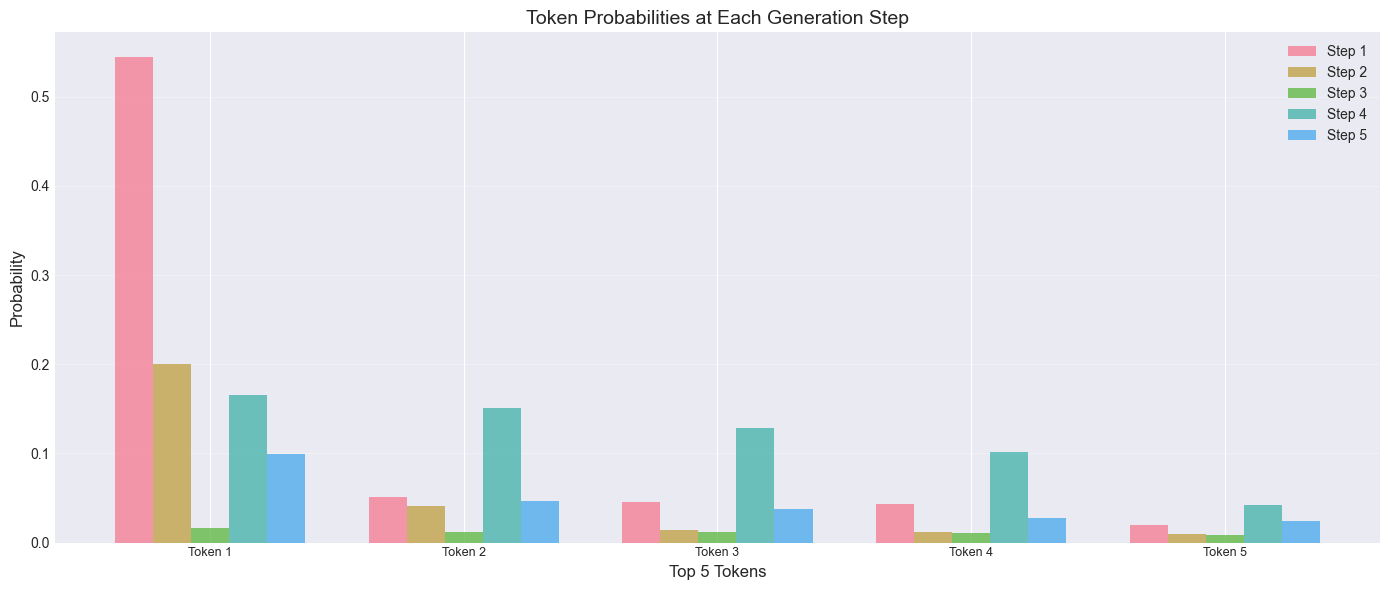


This shows how the model's confidence (probabilities) changes
as it generates each new token in the sequence.


In [ ]:
# Visualize token probabilities during generation
print("=" * 80)
print("TOKEN PROBABILITIES DURING GENERATION")
print("=" * 80)

prompt = "The news reported"
input_ids = tokenizer_gpt2.encode(prompt, return_tensors="pt")

# Generate and track probabilities
step_probs = []
step_tokens = []

current_ids = input_ids.clone()
for step in range(5):
    with torch.no_grad():
        outputs = model(current_ids)
        logits = outputs.logits[0, -1, :]
        probs = F.softmax(logits, dim=-1)
        
        # Get top 5
        top_probs, top_indices = torch.topk(probs, 5)
        step_probs.append(top_probs.numpy())
        step_tokens.append([tokenizer_gpt2.decode([idx.item()])[:15] for idx in top_indices])
        
        # Select top token
        next_token_id = top_indices[0].item()
        current_ids = torch.cat([current_ids, torch.tensor([[next_token_id]])], dim=1)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

x_pos = np.arange(5)
width = 0.15

for i, (probs_step, tokens_step) in enumerate(zip(step_probs, step_tokens)):
    ax.bar(x_pos + i*width, probs_step, width, label=f'Step {i+1}', alpha=0.7)

ax.set_xlabel('Top 5 Tokens', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Token Probabilities at Each Generation Step', fontsize=14)
ax.set_xticks(x_pos + width * 2)
ax.set_xticklabels([f'Token {i+1}' for i in range(5)], fontsize=9)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThis shows how the model's confidence (probabilities) changes")
print("as it generates each new token in the sequence.")
